In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from utils.paths import DATA_RAW_DIR

In [7]:
path_happiness = str(DATA_RAW_DIR / "happiness.csv")
print(Path(path_happiness).exists())
df_happiness = pd.read_csv(path_happiness, sep=",", encoding="utf-8")
df_happiness.head()

True


,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [8]:
df_happiness.columns

Index(['country', 'rank', 'score', 'high', 'low', 'gdp', 'family', 'lifexp',
       'freedom', 'generosity', 'corruption', 'dystopia'],
      dtype='object')

In [10]:


# 1. Feature matrix and target
X = df_happiness.drop(columns=["country", "score", "rank"], axis=1)
y = df_happiness["score"]

# 2. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Hyperparameter distributions
param_distributions = {
    'n_estimators': np.arange(1, 15, 1),
    'max_depth': [None] + list(np.arange(1, 15, 1)),
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2'] 
}

# 4. Base model
model_rf = RandomForestRegressor(random_state=42)

# 5. Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 6. Fit to training set
random_search.fit(X_train, y_train)

# 7. Best estimator evaluation on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 8. Print results
print("\n✅ Randomized Search completed successfully")
print("🔧 Best Parameters:", random_search.best_params_)
print("📈 Test Mean Squared Error (MSE):", f"{mse:.4f}")
print("🎯 Test R² Score:", f"{r2:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Randomized Search completed successfully
🔧 Best Parameters: {'n_estimators': np.int64(12), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 'sqrt', 'max_depth': np.int64(9), 'criterion': 'squared_error'}
📈 Test Mean Squared Error (MSE): 0.0070
🎯 Test R² Score: 0.9940


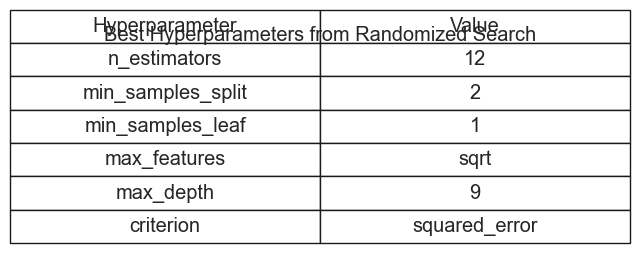

In [13]:
# visualization of best hyperparameters as a table
plt.figure(figsize=(8, 2))
sns.set(font_scale=1.2)
table_data = [[k, v] for k, v in random_search.best_params_.items()]
table = plt.table(cellText=table_data, colLabels=["Hyperparameter", "Value"], loc="center", cellLoc="center")
table.scale(1, 2)
plt.axis("off")
plt.title("Best Hyperparameters from Randomized Search")
plt.show()


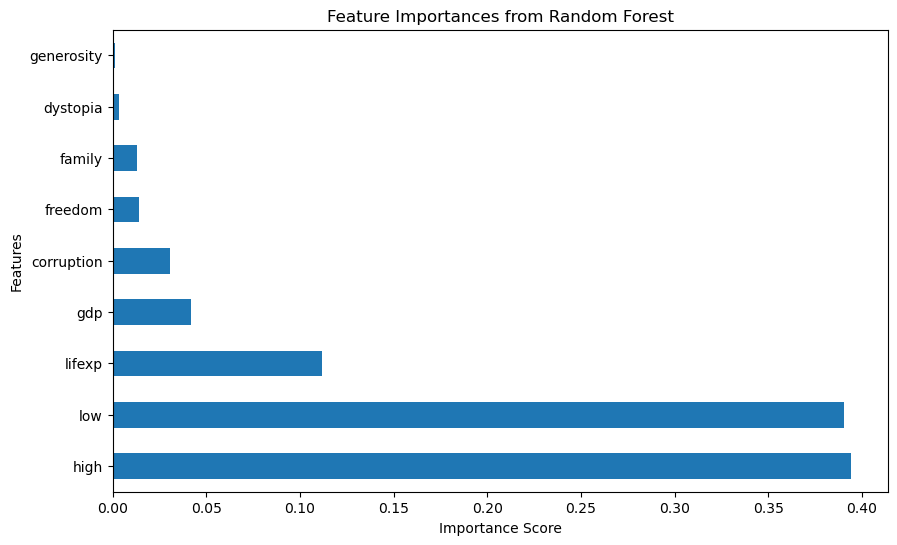

In [ ]:
# visualization feature importances
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns) # type: ignore
feature_importances.sort_values(ascending=False).plot(kind='barh')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()